In [1]:
# --- setup ---
import os, re, random, math, shutil
from glob import glob
from pathlib import Path
from collections import Counter

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as img
from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Input
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications.densenet import preprocess_input as preprocess_densenet

from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score

2025-10-20 11:46:43.134110: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760960803.334424      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760960803.387899      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Groundtruth Set

In [3]:
# stratified split into 70-15-15 (+ augmented to balance the trainset)
train_dir =  "/kaggle/input/ham10000-semented-gt-set/split_dir/augmented_trainset"
val_dir = "/kaggle/input/ham10000-semented-gt-set/split_dir/val"
test_dir = "/kaggle/input/ham10000-semented-gt-set/split_dir/test"

In [4]:
# get the each class's name
train_classes = os.listdir(train_dir)
test_classes = os.listdir(test_dir)

In [5]:
# count the number of images per class
def count_images_by_class(directory):
    class_counts = {}
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            class_counts[class_name] = len(os.listdir(class_path))
    return class_counts

In [6]:
train_counts = count_images_by_class(train_dir)
print(train_counts)

{'MEL': 4693, 'VASC': 4693, 'DF': 4693, 'NV': 4693, 'BKL': 4693, 'AKIEC': 4693, 'BCC': 4693}


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


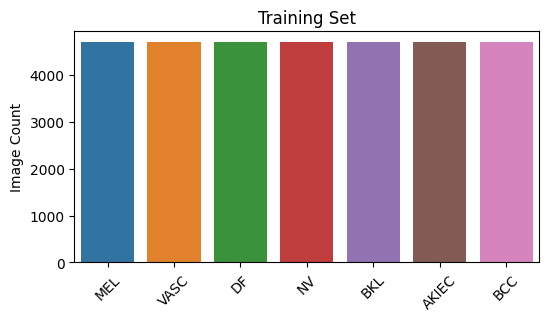

In [7]:
# plot counts for train and test set
def plot_class_counts(class_counts, title):
  plt.figure(figsize=(6,3))
  sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette="tab10")
  plt.title(title)
  plt.ylabel("Image Count")
  plt.xticks(rotation=45)
  plt.show()

# display
plot_class_counts(train_counts, "Training Set")

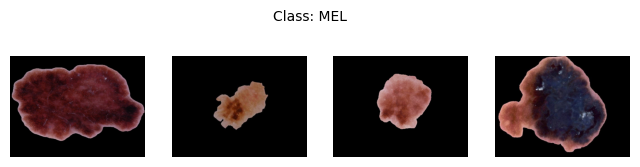

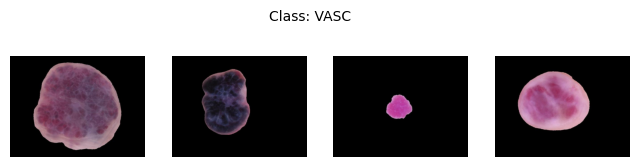

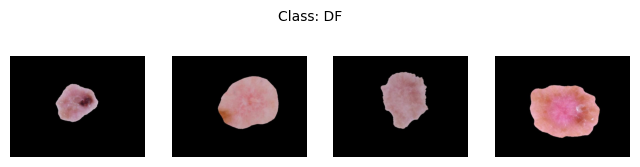

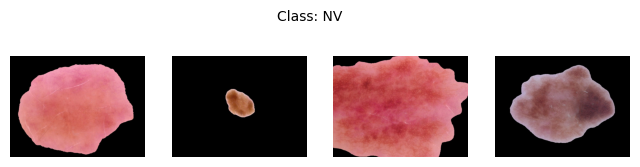

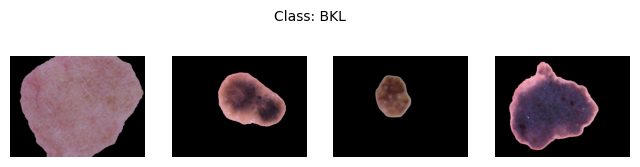

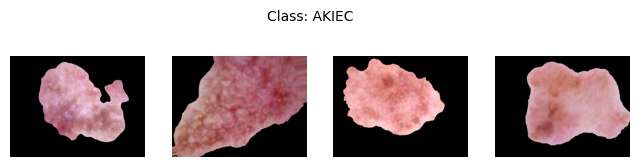

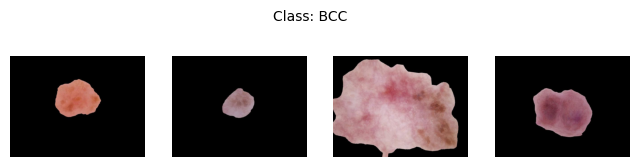

In [8]:
def display_images_per_class(directory, n_images=4):
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            image_files = os.listdir(class_path)[:n_images]
            plt.figure(figsize=(8, 2))
            plt.suptitle(f"Class: {class_name}", fontsize=10)
            for i, img_file in enumerate(image_files):
                img_path = os.path.join(class_path, img_file)
                img = Image.open(img_path)
                plt.subplot(1, n_images, i + 1)
                plt.imshow(img)
                plt.axis('off')
            plt.show()

# Display 4 images per class from the training data
display_images_per_class(train_dir)

In [9]:
# DenseNet preprocess expects mean-std normalization to ImageNet. For best consistency

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

from tensorflow.keras.applications.densenet import preprocess_input as preprocess_densenet

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_densenet)
val_datagen   = ImageDataGenerator(preprocessing_function=preprocess_densenet)
test_datagen  = ImageDataGenerator(preprocessing_function=preprocess_densenet)

train_data = train_datagen.flow_from_directory(train_dir, target_size=IMG_SIZE,
                                               batch_size=BATCH_SIZE, class_mode='categorical', shuffle=True)
val_data   = val_datagen.flow_from_directory(val_dir, target_size=IMG_SIZE,
                                             batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False)
test_data  = test_datagen.flow_from_directory(test_dir, target_size=IMG_SIZE,
                                              batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False)

Found 32851 images belonging to 7 classes.
Found 1502 images belonging to 7 classes.
Found 1506 images belonging to 7 classes.


In [10]:
base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base

# Add custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)                           # Dropout
output = Dense(7, activation='softmax')(x)    # Output for 7 classes

model = Model(inputs=base_model.input, outputs=output)

I0000 00:00:1760960832.992406      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1760960832.993272      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [11]:
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [12]:
# model.summary()

In [13]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True
)

# Reduce learning rate callback
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6
)

callbacks = [early_stop, reduce_lr]

In [14]:
history1 = model.fit(
    train_data,
    epochs=10,
    validation_data=val_data,
    callbacks=callbacks,              
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


I0000 00:00:1760960871.198515      85 service.cc:148] XLA service 0x7ad884004bb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1760960871.199498      85 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1760960871.199527      85 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1760960875.860529      85 cuda_dnn.cc:529] Loaded cuDNN version 90300


   1/1027 ━━━━━━━━━━━━━━━━━━━━ 16:18:32 57s/step - accuracy: 0.1562 - loss: 2.3836

I0000 00:00:1760960896.260699      85 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1027/1027 ━━━━━━━━━━━━━━━━━━━━ 359s 294ms/step - accuracy: 0.4477 - loss: 1.4717 - val_accuracy: 0.6525 - val_loss: 0.9554 - learning_rate: 1.0000e-04
Epoch 2/10
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 129s 126ms/step - accuracy: 0.6908 - loss: 0.8473 - val_accuracy: 0.7330 - val_loss: 0.7093 - learning_rate: 1.0000e-04
Epoch 3/10
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 130s 127ms/step - accuracy: 0.7432 - loss: 0.6960 - val_accuracy: 0.7483 - val_loss: 0.6666 - learning_rate: 1.0000e-04
Epoch 4/10
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 130s 127ms/step - accuracy: 0.7880 - loss: 0.5816 - val_accuracy: 0.7570 - val_loss: 0.6440 - learning_rate: 1.0000e-04
Epoch 5/10
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 130s 126ms/step - accuracy: 0.8073 - loss: 0.5243 - val_accuracy: 0.7390 - val_loss: 0.6607 - learning_rate: 1.0000e-04
Epoch 6/10
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 130s 127ms/step - accuracy: 0.8284 - loss: 0.4659 - val_accuracy: 0.7530 - val_loss: 0.6527 - learning_rate: 1.0000e-04
Epoch 7/10
1027/1027 ━━━━━━━━━━━━━━━━━━

In [15]:
# Unfreeze all layers
base_model.trainable = True

# Recompile with a lower learning rate for fine-tuning
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Continue training
history2 = model.fit(
    train_data,
    epochs=10,
    validation_data=val_data,
    callbacks=callbacks,
)

Epoch 1/10
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 1161s 741ms/step - accuracy: 0.6867 - loss: 1.0870 - val_accuracy: 0.7770 - val_loss: 0.6346 - learning_rate: 1.0000e-05
Epoch 2/10
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 496s 482ms/step - accuracy: 0.8954 - loss: 0.2918 - val_accuracy: 0.7823 - val_loss: 0.6261 - learning_rate: 1.0000e-05
Epoch 3/10
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 495s 482ms/step - accuracy: 0.9420 - loss: 0.1711 - val_accuracy: 0.8096 - val_loss: 0.5958 - learning_rate: 1.0000e-05
Epoch 4/10
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 494s 481ms/step - accuracy: 0.9672 - loss: 0.1026 - val_accuracy: 0.7983 - val_loss: 0.6400 - learning_rate: 1.0000e-05
Epoch 5/10
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 495s 482ms/step - accuracy: 0.9757 - loss: 0.0719 - val_accuracy: 0.8336 - val_loss: 0.6911 - learning_rate: 1.0000e-05
Epoch 6/10
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 495s 482ms/step - accuracy: 0.9813 - loss: 0.0552 - val_accuracy: 0.8269 - val_loss: 0.6965 - learning_rate: 1.0000e-05
Epoch 7/10
1027/1027 ━━━━━━

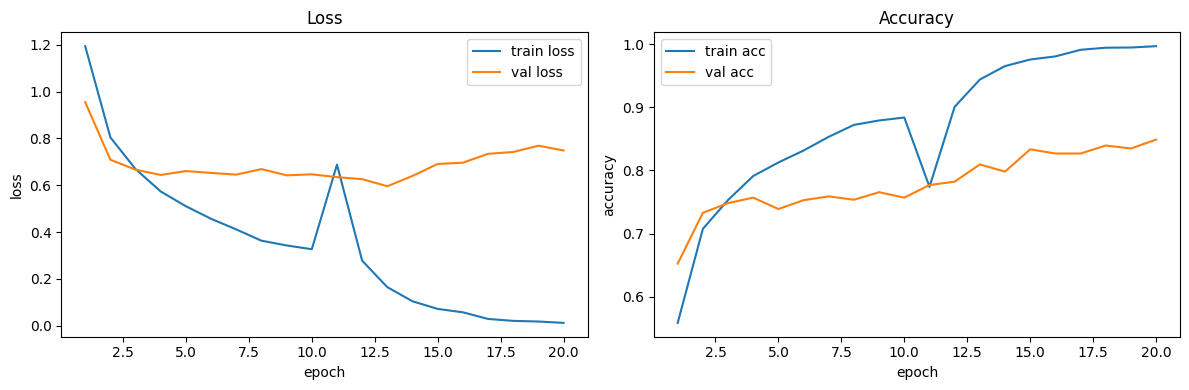

In [16]:
# ---- metrics & plotting helpers ----
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_curve, auc,
    precision_recall_curve
)
from sklearn.preprocessing import label_binarize
import numpy as np, matplotlib.pyplot as plt, seaborn as sns, pandas as pd

import itertools, os, math

def merge_histories(h1, h2):
    merged = {}
    keys = set(list(h1.history.keys()) + list(h2.history.keys()))
    for k in keys:
        merged[k] = list(h1.history.get(k, [])) + list(h2.history.get(k, []))
    return merged

hist = merge_histories(history1, history2)
epochs = range(1, len(hist['loss']) + 1)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(epochs, hist['loss'], label='train loss')
plt.plot(epochs, hist['val_loss'], label='val loss')
plt.xlabel('epoch'); plt.ylabel('loss'); plt.title('Loss'); plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, hist['accuracy'], label='train acc')
plt.plot(epochs, hist['val_accuracy'], label='val acc')
plt.xlabel('epoch'); plt.ylabel('accuracy'); plt.title('Accuracy'); plt.legend()
plt.tight_layout(); plt.show()

In [17]:
# Ensure test_data was created with shuffle=False (you did this already)
class_indices = test_data.class_indices
idx_to_class = {v:k for k,v in class_indices.items()}
class_names = [idx_to_class[i] for i in range(len(idx_to_class))]

# Collect predictions
y_prob = model.predict(test_data, verbose=1)        # shape: (N, 7)
y_pred = np.argmax(y_prob, axis=1)                  # predicted class indices
y_true = test_data.classes                          # ground truth indices aligned with generator order

# Quick test accuracy
test_acc = (y_pred == y_true).mean()
print(f"Test accuracy: {test_acc*100:.2f}%  (N={len(y_true)})")


precision_macro = precision_score(y_true, y_pred, average='macro')
recall_macro = recall_score(y_true, y_pred, average='macro')
f1_macro = f1_score(y_true, y_pred, average='macro')

print(f"Macro Precision: {precision_macro:.3f}")
print(f"Macro Recall: {recall_macro:.3f}")
print(f"Macro F1: {f1_macro:.3f}")

48/48 ━━━━━━━━━━━━━━━━━━━━ 58s 780ms/step
Test accuracy: 80.74%  (N=1506)
Macro Precision: 0.697
Macro Recall: 0.667
Macro F1: 0.674


In [18]:
report_str = classification_report(
    y_true, y_pred, target_names=class_names, digits=4
)
print(report_str)

# # DataFrame view
# report_dict = classification_report(
#     y_true, y_pred, target_names=class_names, output_dict=True, digits=4
# )
# pd.DataFrame(report_dict).T

              precision    recall  f1-score   support

       AKIEC     0.6098    0.5000    0.5495        50
         BCC     0.6591    0.7436    0.6988        78
         BKL     0.5918    0.7030    0.6427       165
          DF     0.6500    0.7222    0.6842        18
         MEL     0.6442    0.4012    0.4945       167
          NV     0.8874    0.9165    0.9017      1006
        VASC     0.8333    0.6818    0.7500        22

    accuracy                         0.8074      1506
   macro avg     0.6965    0.6669    0.6745      1506
weighted avg     0.8034    0.8074    0.8011      1506



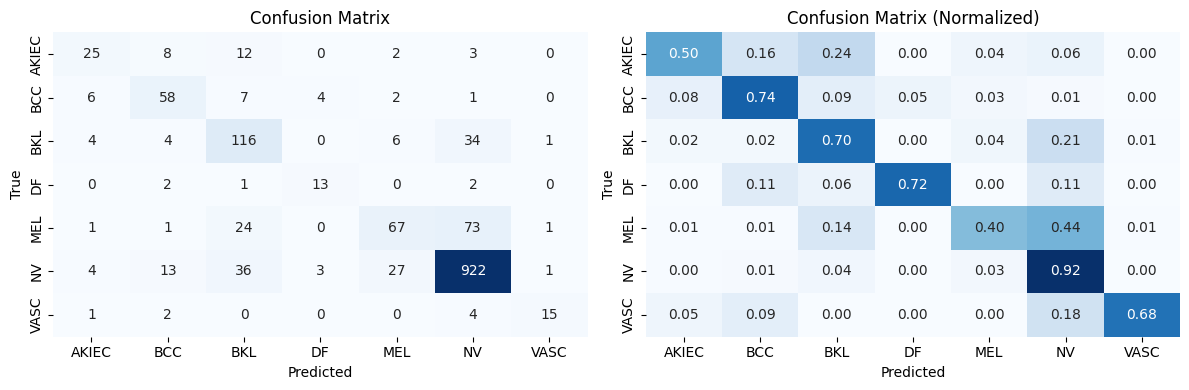

In [19]:
cm = confusion_matrix(y_true, y_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1, keepdims=True)

fig, axes = plt.subplots(1, 2, figsize=(12,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=class_names, yticklabels=class_names, ax=axes[0])
axes[0].set_title('Confusion Matrix'); axes[0].set_xlabel('Predicted'); axes[0].set_ylabel('True')

sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues', cbar=False,
            xticklabels=class_names, yticklabels=class_names, ax=axes[1])
axes[1].set_title('Confusion Matrix (Normalized)'); axes[1].set_xlabel('Predicted'); axes[1].set_ylabel('True')

plt.tight_layout(); plt.show()

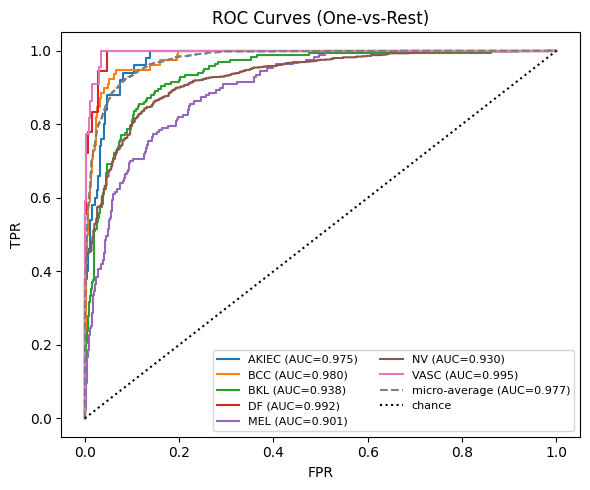

Per-class AUC: {'AKIEC': 0.9751236263736265, 'BCC': 0.9802215758098112, 'BKL': 0.9383906175852484, 'DF': 0.9921968339307049, 'MEL': 0.9007213355216379, 'NV': 0.9296133200795229, 'VASC': 0.9948848321489832}
Micro AUC: 0.9767 | Macro AUC: 0.9587


In [20]:
# Binarize labels for one-vs-rest ROC/AUC
y_true_bin = label_binarize(y_true, classes=list(range(len(class_names))))  # (N, C)

# Per-class ROC
plt.figure(figsize=(6,5))
auc_per_class = {}
for i, name in enumerate(class_names):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    auc_per_class[name] = roc_auc
    plt.plot(fpr, tpr, label=f'{name} (AUC={roc_auc:.3f})')
# Micro/macro
fpr_micro, tpr_micro, _ = roc_curve(y_true_bin.ravel(), y_prob.ravel())
auc_micro = auc(fpr_micro, tpr_micro)
plt.plot(fpr_micro, tpr_micro, linestyle='--', label=f'micro-average (AUC={auc_micro:.3f})')

# Macro AUC
auc_macro = np.mean(list(auc_per_class.values()))
plt.plot([0,1],[0,1], 'k:', label='chance')
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC Curves (One-vs-Rest)')
plt.legend(fontsize=8, ncol=2); plt.tight_layout(); plt.show()

print("Per-class AUC:", auc_per_class)
print(f"Micro AUC: {auc_micro:.4f} | Macro AUC: {auc_macro:.4f}")

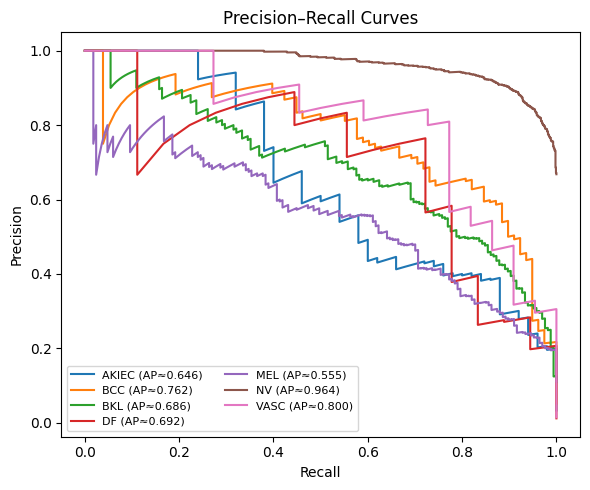

Per-class AP (approx): {'AKIEC': 0.6464459816158392, 'BCC': 0.7616302722011612, 'BKL': 0.686354952946458, 'DF': 0.6922677728520555, 'MEL': 0.5547902714169362, 'NV': 0.9638568212939539, 'VASC': 0.7996491109146082}
Macro AP (approx): 0.7293


In [21]:
plt.figure(figsize=(6,5))
ap_per_class = {}
for i, name in enumerate(class_names):
    precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_prob[:, i])
    # approximate AP by trapezoidal rule (sklearn.average_precision_score also works)
    ap = np.trapz(precision[::-1], recall[::-1])
    ap_per_class[name] = ap
    plt.plot(recall, precision, label=f'{name} (AP≈{ap:.3f})')

plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title('Precision–Recall Curves')
plt.legend(fontsize=8, ncol=2); plt.tight_layout(); plt.show()

print("Per-class AP (approx):", ap_per_class)
print(f"Macro AP (approx): {np.mean(list(ap_per_class.values())):.4f}")

# Transfer learning with SegmentedSet by Unet model

In [22]:
# PATHS)
unet_train_dir = "/kaggle/input/ham10000-semented-unet-set/segmented_applied_fullframe/augmented_trainset"
unet_val_dir   = "/kaggle/input/ham10000-semented-unet-set/segmented_applied_fullframe/val"
unet_test_dir  = "/kaggle/input/ham10000-semented-unet-set/segmented_applied_fullframe/test"

In [23]:
# Reuse the SAME preprocessing & IMG_SIZE/BATCH_SIZE ---
unet_train_gen = ImageDataGenerator(preprocessing_function=preprocess_densenet)
unet_val_gen   = ImageDataGenerator(preprocessing_function=preprocess_densenet)
unet_test_gen  = ImageDataGenerator(preprocessing_function=preprocess_densenet)

In [24]:
unet_train_data = unet_train_gen.flow_from_directory(
    unet_train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    classes=class_names   # <- ensures same mapping as before
)
unet_val_data = unet_val_gen.flow_from_directory(
    unet_val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    classes=class_names
)
unet_test_data = unet_test_gen.flow_from_directory(
    unet_test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    classes=class_names
)

Found 32851 images belonging to 7 classes.
Found 1502 images belonging to 7 classes.
Found 1506 images belonging to 7 classes.


In [25]:
# fine-tune on UNet-set
base_model.trainable = True
model.compile(optimizer=Adam(learning_rate=5e-6),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [26]:
# model.summary()

In [27]:
history3 = model.fit(
    unet_train_data,
    epochs=30,
    validation_data=unet_val_data,
    callbacks=callbacks,
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 1144s 737ms/step - accuracy: 0.8472 - loss: 0.4946 - val_accuracy: 0.8668 - val_loss: 0.3952 - learning_rate: 5.0000e-06
Epoch 2/30
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 498s 485ms/step - accuracy: 0.9260 - loss: 0.2118 - val_accuracy: 0.8735 - val_loss: 0.3795 - learning_rate: 5.0000e-06
Epoch 3/30
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 495s 482ms/step - accuracy: 0.9543 - loss: 0.1320 - val_accuracy: 0.8735 - val_loss: 0.3980 - learning_rate: 5.0000e-06
Epoch 4/30
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 495s 481ms/step - accuracy: 0.9685 - loss: 0.0928 - val_accuracy: 0.8755 - val_loss: 0.4193 - learning_rate: 5.0000e-06
Epoch 5/30
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 494s 481ms/step - accuracy: 0.9791 - loss: 0.0632 - val_accuracy: 0.8848 - val_loss: 0.4186 - learning_rate: 5.0000e-06
Epoch 6/30
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 495s 482ms/step - accuracy: 0.9849 - loss: 0.0459 - val_accuracy: 0.8835 - val_loss: 0.4348 - learning_rate: 2.5000e-06
Epoch 7/30
1027/1027 ━━━━━━

In [28]:
# Predictions
y_prob_unet = model.predict(unet_test_data, verbose=1)
y_pred_unet = np.argmax(y_prob_unet, axis=1)
y_true_unet = unet_test_data.classes

# Accuracy
acc_unet = (y_pred_unet == y_true_unet).mean()
print(f"[UNet test] Accuracy: {acc_unet*100:.2f}% (N={len(y_true_unet)})")

# Macro metrics
prec_macro_unet = precision_score(y_true_unet, y_pred_unet, average='macro')
rec_macro_unet  = recall_score(y_true_unet,  y_pred_unet, average='macro')
f1_macro_unet   = f1_score(y_true_unet,      y_pred_unet, average='macro')
print(f"[UNet test] Macro P/R/F1: {prec_macro_unet:.3f} / {rec_macro_unet:.3f} / {f1_macro_unet:.3f}")

48/48 ━━━━━━━━━━━━━━━━━━━━ 54s 749ms/step
[UNet test] Accuracy: 85.86% (N=1506)
[UNet test] Macro P/R/F1: 0.805 / 0.771 / 0.785


In [29]:
# Classification report
report_unet_str = classification_report(y_true_unet, y_pred_unet, target_names=class_names, digits=4)
print(report_unet_str)

              precision    recall  f1-score   support

       AKIEC     0.7609    0.7000    0.7292        50
         BCC     0.8219    0.7692    0.7947        78
         BKL     0.6890    0.6848    0.6869       165
          DF     0.7619    0.8889    0.8205        18
         MEL     0.7444    0.5928    0.6600       167
          NV     0.9067    0.9463    0.9261      1006
        VASC     0.9474    0.8182    0.8780        22

    accuracy                         0.8586      1506
   macro avg     0.8046    0.7715    0.7851      1506
weighted avg     0.8545    0.8586    0.8551      1506



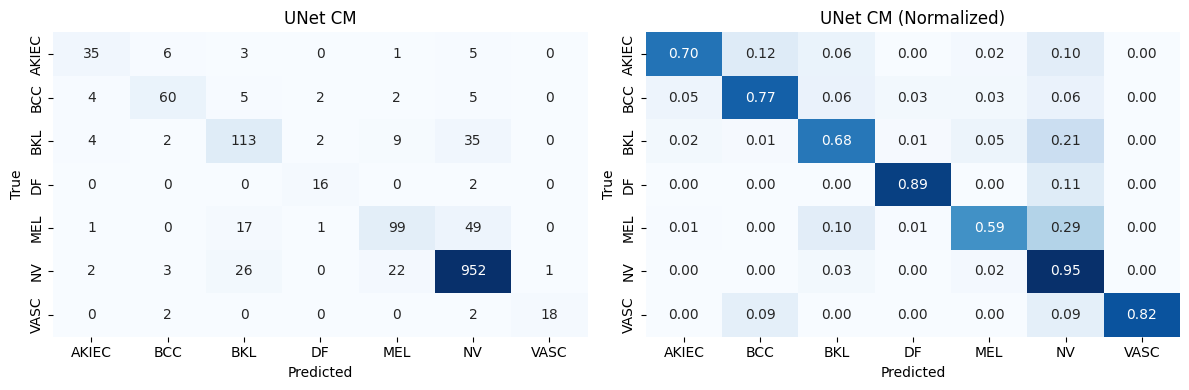

In [30]:
# DataFrame report
report_unet_df = classification_report(y_true_unet, y_pred_unet, target_names=class_names, output_dict=True, digits=4)
report_unet_df = pd.DataFrame(report_unet_df).T

# Confusion matrices (bug fix: use consistent variable names)
cm = confusion_matrix(y_true_unet, y_pred_unet)
cm_norm = cm.astype('float') / cm.sum(axis=1, keepdims=True)

fig, axes = plt.subplots(1, 2, figsize=(12,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=class_names, yticklabels=class_names, ax=axes[0])
axes[0].set_title('UNet CM'); axes[0].set_xlabel('Predicted'); axes[0].set_ylabel('True')

sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues', cbar=False,
            xticklabels=class_names, yticklabels=class_names, ax=axes[1])
axes[1].set_title('UNet CM (Normalized)'); axes[1].set_xlabel('Predicted'); axes[1].set_ylabel('True')

plt.tight_layout(); plt.show()

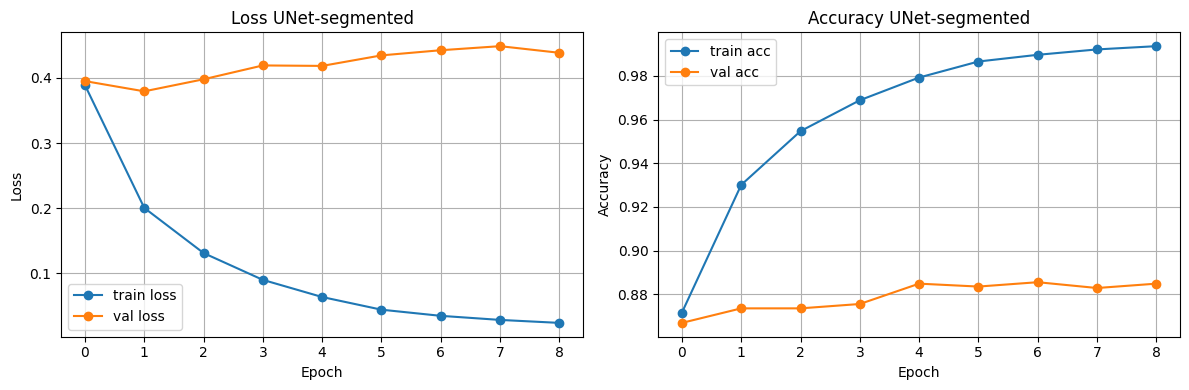

In [31]:
# --- Plot training curves for the UNet-set stage ---
plt.figure(figsize=(12,4))

# Left: Loss
plt.subplot(1,2,1)
plt.plot(history3.history['loss'], label='train loss', marker='o')
plt.plot(history3.history['val_loss'], label='val loss', marker='o')
plt.title('Loss UNet-segmented')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Right: Accuracy
plt.subplot(1,2,2)
plt.plot(history3.history['accuracy'], label='train acc', marker='o')
plt.plot(history3.history['val_accuracy'], label='val acc', marker='o')
plt.title('Accuracy UNet-segmented')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

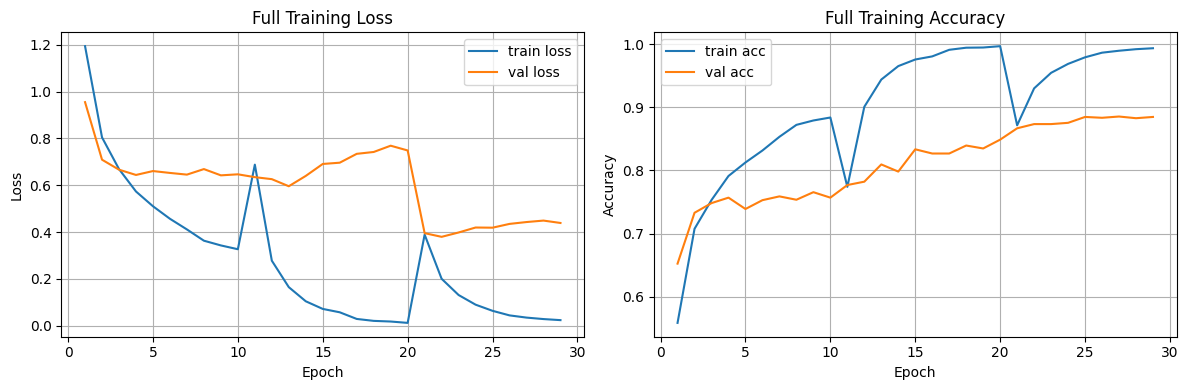

In [32]:
def merge_histories(*histories):
    merged = {}
    for h in histories:
        for k, v in h.history.items():
            merged.setdefault(k, []).extend(v)
    return merged

hist_total = merge_histories(history1, history2, history3)
epochs_total = range(1, len(hist_total['loss']) + 1)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(epochs_total, hist_total['loss'], label='train loss')
plt.plot(epochs_total, hist_total['val_loss'], label='val loss')
plt.title('Full Training Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.grid(True)

plt.subplot(1,2,2)
plt.plot(epochs_total, hist_total['accuracy'], label='train acc')
plt.plot(epochs_total, hist_total['val_accuracy'], label='val acc')
plt.title('Full Training Accuracy')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.grid(True)

plt.tight_layout(); plt.show()

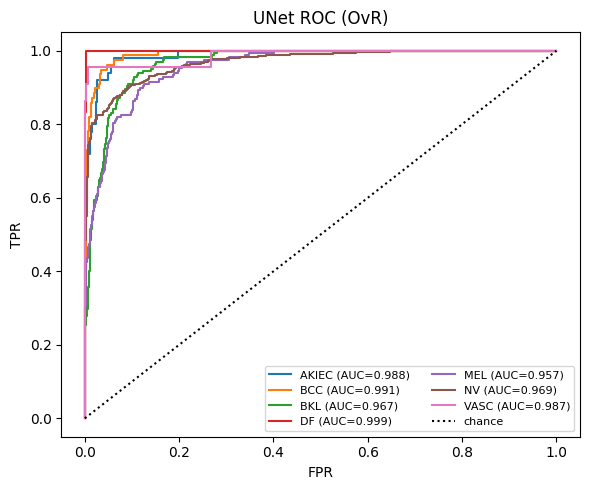

Per-class AUC (UNet): {'AKIEC': 0.9876510989010989, 'BCC': 0.9909681821446528, 'BKL': 0.9666508485300432, 'DF': 0.9994026284348865, 'MEL': 0.9567467007732109, 'NV': 0.9693856858846919, 'VASC': 0.987258024993874}
Micro AUC: 0.9892 | Macro AUC: 0.9797


In [33]:
# One-vs-rest ROC / AUC on UNet-set
y_true_bin_unet = label_binarize(y_true_unet, classes=list(range(len(class_names))))

plt.figure(figsize=(6,5))
auc_per_class_unet = {}
for i, name in enumerate(class_names):
    fpr, tpr, _ = roc_curve(y_true_bin_unet[:, i], y_prob_unet[:, i])
    roc_auc = auc(fpr, tpr)
    auc_per_class_unet[name] = roc_auc
    plt.plot(fpr, tpr, label=f'{name} (AUC={roc_auc:.3f})')

fpr_micro, tpr_micro, _ = roc_curve(y_true_bin_unet.ravel(), y_prob_unet.ravel())
auc_micro_unet = auc(fpr_micro, tpr_micro)

auc_macro_unet = np.mean(list(auc_per_class_unet.values()))
plt.plot([0,1],[0,1],'k:',label='chance')
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('UNet ROC (OvR)')
plt.legend(fontsize=8, ncol=2); plt.tight_layout(); plt.show()

print("Per-class AUC (UNet):", auc_per_class_unet)
print(f"Micro AUC: {auc_micro_unet:.4f} | Macro AUC: {auc_macro_unet:.4f}")

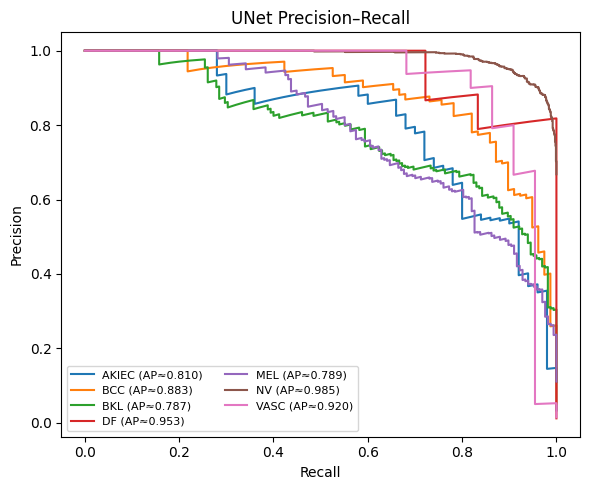

Per-class AP (UNet): {'AKIEC': 0.8098419485974172, 'BCC': 0.88326700095279, 'BKL': 0.7872015922065724, 'DF': 0.9534922980356417, 'MEL': 0.7891035340992423, 'NV': 0.9852785876973967, 'VASC': 0.9204458212552165}
Macro AP (UNet): 0.8755


In [34]:
# PR curves + AP on UNet-set
plt.figure(figsize=(6,5))
ap_per_class_unet = {}
for i, name in enumerate(class_names):
    precision, recall, _ = precision_recall_curve(y_true_bin_unet[:, i], y_prob_unet[:, i])
    ap = np.trapz(precision[::-1], recall[::-1])
    ap_per_class_unet[name] = ap
    plt.plot(recall, precision, label=f'{name} (AP≈{ap:.3f})')
plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title('UNet Precision–Recall')
plt.legend(fontsize=8, ncol=2); plt.tight_layout(); plt.show()

print("Per-class AP (UNet):", ap_per_class_unet)
print(f"Macro AP (UNet): {np.mean(list(ap_per_class_unet.values())):.4f}")